In [1]:
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d vencerlanz09/bottle-synthetic-images-dataset

 99% 1.25G/1.26G [00:09<00:00, 119MB/s] 
100% 1.26G/1.26G [00:09<00:00, 141MB/s]


In [3]:
!unzip /content/bottle-synthetic-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010001.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010002.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010003.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010004.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010005.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010006.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010007.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010008.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010009.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010010.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010011.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00010012.jpg  
 

In [4]:
base_dir = '/content/Bottle Images/Bottle Images'

In [5]:
import os
char = os.listdir(base_dir)
total=0
for i in char:
  total += len(os.listdir(f'/content/Bottle Images/Bottle Images/{i}'))
  print(f"{i} : ",len(os.listdir(f'/content/Bottle Images/Bottle Images/{i}')))
print(f"Total Image : {total}")

Soda Bottle :  5000
Plastic Bottles :  5000
Water Bottle :  5000
Wine Bottle :  5000
Beer Bottles :  5000
Total Image : 25000


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

In [7]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    class_mode='categorical',
    subset='validation')

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [8]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(5, activation='softmax')  
])

In [9]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [10]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
      self.model.stop_training = True
      print("Training stopped, target reached.")

In [11]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=150,
                    verbose=2,
                    callbacks=[MyCallback()])

Epoch 1/150
625/625 - 85s - loss: 1.2103 - accuracy: 0.5036 - val_loss: 1.0003 - val_accuracy: 0.6572 - 85s/epoch - 135ms/step
Epoch 2/150
625/625 - 73s - loss: 0.8782 - accuracy: 0.6929 - val_loss: 0.8436 - val_accuracy: 0.7142 - 73s/epoch - 117ms/step
Epoch 3/150
625/625 - 73s - loss: 0.7105 - accuracy: 0.7592 - val_loss: 0.7555 - val_accuracy: 0.7424 - 73s/epoch - 116ms/step
Epoch 4/150
625/625 - 74s - loss: 0.5655 - accuracy: 0.8120 - val_loss: 0.6255 - val_accuracy: 0.8016 - 74s/epoch - 118ms/step
Epoch 5/150
625/625 - 73s - loss: 0.4413 - accuracy: 0.8569 - val_loss: 0.5676 - val_accuracy: 0.8226 - 73s/epoch - 116ms/step
Epoch 6/150
625/625 - 72s - loss: 0.3705 - accuracy: 0.8791 - val_loss: 0.5715 - val_accuracy: 0.8308 - 72s/epoch - 115ms/step
Epoch 7/150
625/625 - 73s - loss: 0.3029 - accuracy: 0.9028 - val_loss: 0.5719 - val_accuracy: 0.8356 - 73s/epoch - 117ms/step
Epoch 8/150
625/625 - 73s - loss: 0.2812 - accuracy: 0.9123 - val_loss: 0.5772 - val_accuracy: 0.8246 - 73s/epo

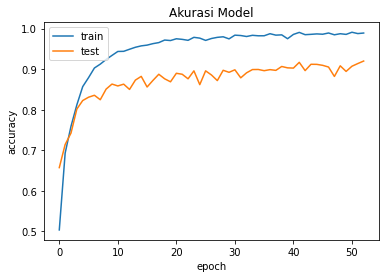

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

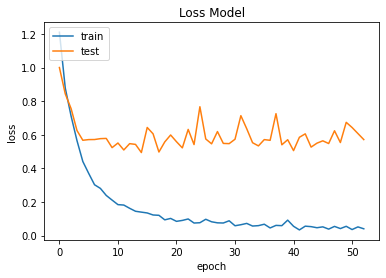

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [17]:
import pathlib
tflite_model_file = pathlib.Path('bottle.tflite')
tflite_model_file.write_bytes(tflite_model)

913108